In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis Dataset

### Statistical anaylsis of the dataset

In [3]:
resume_csv_path= '/kaggle/input/resume-data/Resume.csv'
df=pd.read_csv(resume_csv_path)
df.head(10)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR
5,11592605,HR GENERALIST Summary Dedic...,"<div class=""fontsize fontface vmargins hmargin...",HR
6,25824789,HR MANAGER Summary HUMAN RES...,"<div class=""fontsize fontface vmargins hmargin...",HR
7,15375009,HR MANAGER Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",HR
8,11847784,HR SPECIALIST Summary Posses...,"<div class=""fontsize fontface vmargins hmargin...",HR
9,32896934,HR CLERK Summary Translates ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df.describe()

,ID
count,2.484000e+03
mean,3.182616e+07
std,2.145735e+07
min,3.547447e+06
25%,1.754430e+07
50%,2.521031e+07
75%,3.611444e+07
max,9.980612e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


### Check missing values

In [6]:
missing_values = df.isnull().sum()
print(missing_values)

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


### Distribution of Categories

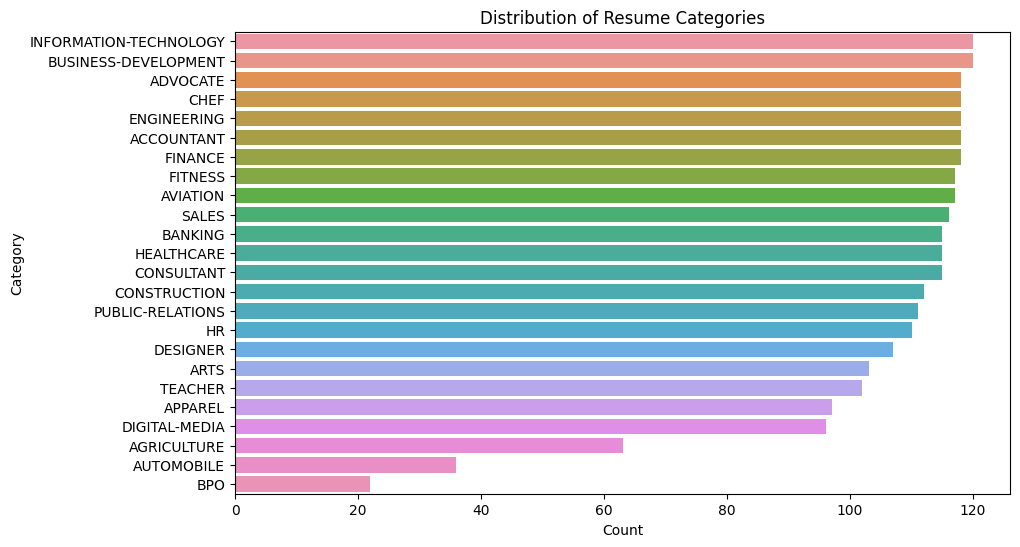

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title('Distribution of Resume Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### Length of Resumes

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


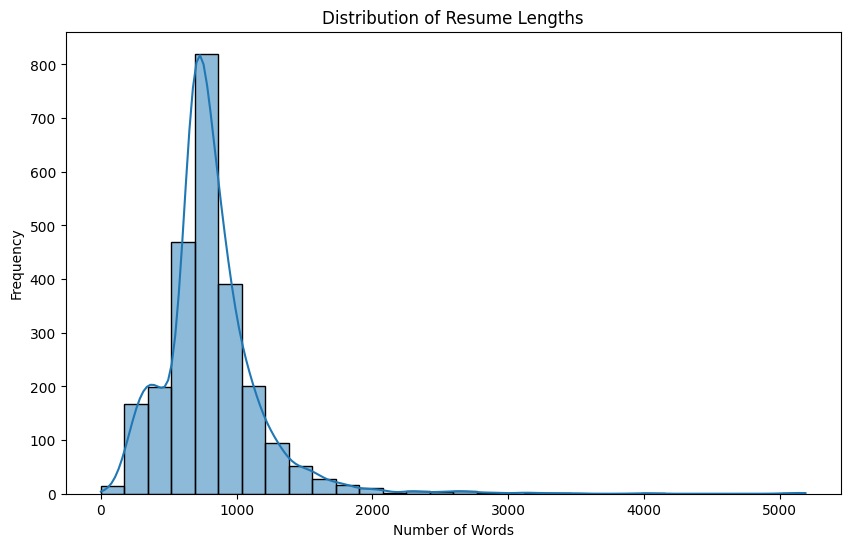

In [8]:
df['resume_length'] = df['Resume_str'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['resume_length'], bins=30, kde=True)
plt.title('Distribution of Resume Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Category vs Resume Length

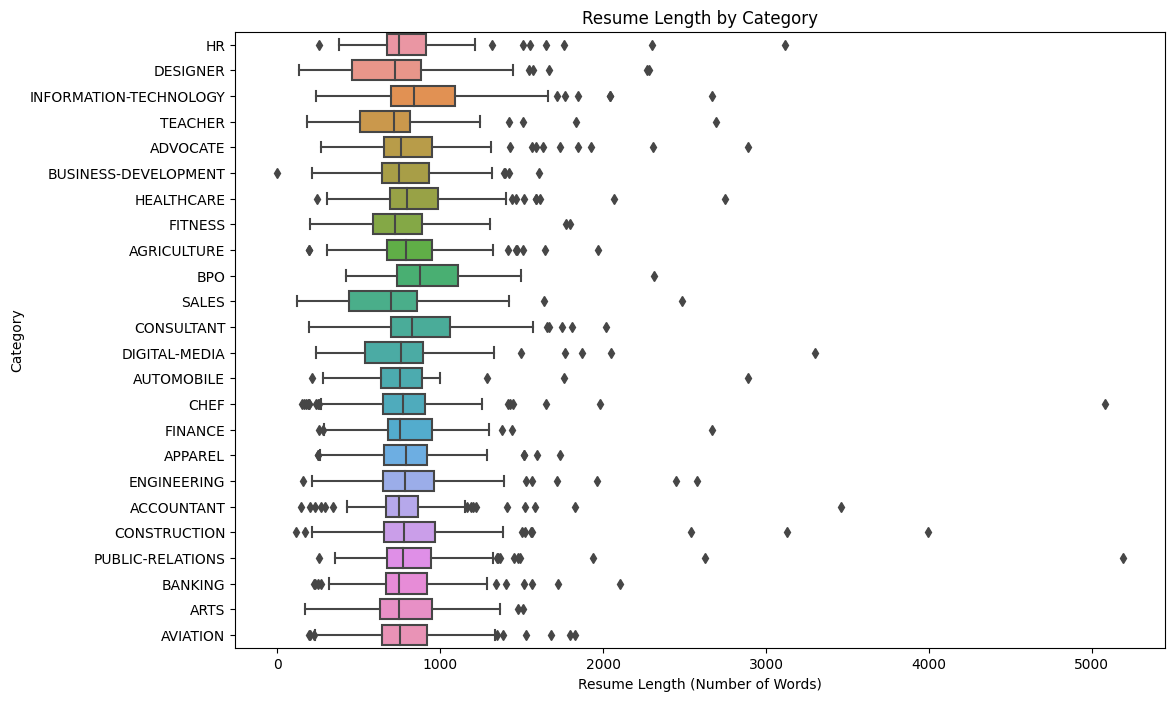

In [9]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='resume_length', y='Category', data=df)
plt.title('Resume Length by Category')
plt.xlabel('Resume Length (Number of Words)')
plt.ylabel('Category')
plt.show()

## Data Processing

### Inspect and Clean Data

In [10]:
df.dropna(inplace=True)
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    return text

df['Resume_str'] = df['Resume_str'].apply(clean_text)

# Label Encoding the target
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

In [11]:
df.head()

,ID,Resume_str,Resume_html,Category,resume_length
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",19,674
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",19,708
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",19,1017
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",19,379
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",19,1206


### Split the dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42)
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1987,)
y_train shape:  (1987,)
X_test shape:  (497,)
y_test shape:  (497,)


In [13]:
print('Sample resume text: \n',X_train[0])
print('sample resume label: \n',y_train[0])

Sample resume text: 
          HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, invento

### Tokenization and Model Configuration

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    return tokenizer(
        texts.tolist(), 
        max_length=512, 
        padding=True, 
        truncation=True, 
        return_tensors="pt"
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
test_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print("Model architecture: \n",model)

Model architecture: 
 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

## Data Loader for model training

In [18]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ResumeDataset(train_encodings, y_train.values)
test_dataset = ResumeDataset(test_encodings, y_test.values)


In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Model training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(20):  # Loop over the dataset multiple times
    model.train()
    for batch in train_loader:
        # Move batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Optimize
        optimizer.step()

    print(f'Epoch {epoch + 1} completed.')


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_34/3545919771.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.


## Model Evaluation

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Classification report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


In [ ]:
def visualize_metrics(accuracy, precision, recall, f1):
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metric_names, y=metric_values)
    plt.title('Model Performance Metrics')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.show()

visualize_metrics(accuracy,precision,recall,f1)

## Save the model

In [ ]:
model.save_pretrained('models/resume_classification_model')
tokenizer.save_pretrained('models/resume_classification_model')